In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import random
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data import Subset
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor


In [2]:
# ---- Set up the Data Pipeline ----

# Transform layer - set size and convert images to tensors
data_transforms = torchvision.transforms.Compose([
    transforms.Resize((128, 128)),
    ToTensor(),
])

# Source training data from local folder 'Dataset'
dataset = datasets.ImageFolder(root='D:/Users/garre/Downloads/Dataset',
                                            transform=data_transforms,
                                            )

# Source test data from local folder 'Test'
test_set = datasets.ImageFolder(root='D:/Users/garre/Downloads/Test',
                                            transform=data_transforms,
                                            )



# Code block to seperate a randomly selected 10% of the data set into a validation set
n = len(dataset)  # total number of examples
n_validation = int(0.1 * n)  # take ~10% for test

validation_index = random.sample(range(n), n_validation)

test_index = []

m = len(validation_index)

for i in range (0, n):
    flag = True
    for j in range (0, m):
        if validation_index[j] == i:
            flag = False
    if flag == True:
        test_index.append(i)

validation_set = Subset(dataset, validation_index)  # take first 10%
train_set = Subset(dataset, test_index)  # take the rest 
# End of code block

# Create a data loader for train data, validation data, and test data with batch sizes of 32 images
training_loader = DataLoader(train_set, batch_size=32, shuffle=True)

validation_loader = DataLoader(validation_set, batch_size=32, shuffle=True)

test_loader = DataLoader(test_set, batch_size=32, shuffle=True)

In [3]:
# Labels to classify data
labels_map = {
    0: "Cat",
    1: "Dog",
    2: "Squirrel",
}

# Test to see data is being loaded correctly and is the correct shape
for i in range (1, 5):
    sample_idx = torch.randint(len(train_set), size=(1,)).item()
    img, label = train_set[sample_idx]
    print(img.shape, labels_map[label])
    
for i in range (1, 5):
    sample_idx = torch.randint(len(validation_set), size=(1,)).item()
    img, label = validation_set[sample_idx]
    print(img.shape, labels_map[label])
    
for X, y in test_loader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

torch.Size([3, 128, 128]) Dog
torch.Size([3, 128, 128]) Dog
torch.Size([3, 128, 128]) Dog
torch.Size([3, 128, 128]) Dog
torch.Size([3, 128, 128]) Cat
torch.Size([3, 128, 128]) Dog
torch.Size([3, 128, 128]) Squirrel
torch.Size([3, 128, 128]) Cat
Shape of X [N, C, H, W]: torch.Size([32, 3, 128, 128])
Shape of y: torch.Size([32]) torch.int64


Training Set Examples:


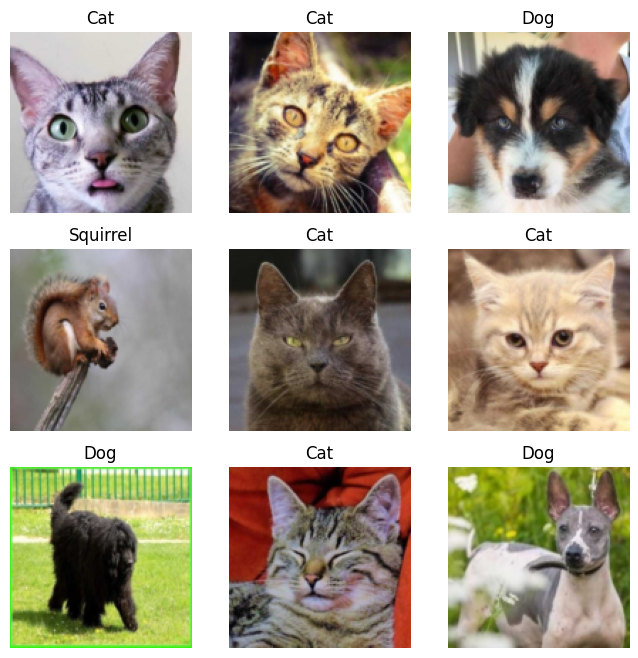

Validation Set Examples:


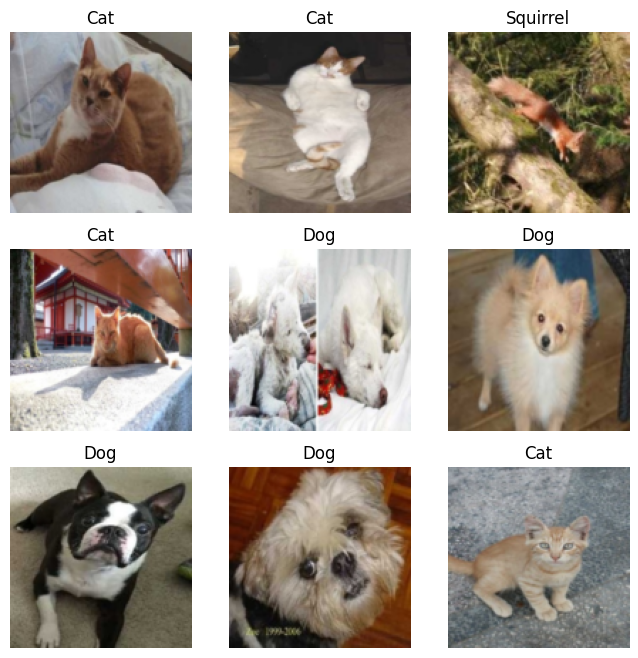

In [4]:
labels_map = {
    0: "Cat",
    1: "Dog",
    2: "Squirrel",
}

# Visualize random samples of the training set
print("Training Set Examples:")
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_set), size=(1,)).item()
    img, label = train_set[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    reordered_img = np.einsum('kij->ijk',img)
    plt.imshow(reordered_img, cmap="gray")
plt.show()

# Visualize random samples of the validation set
print("Validation Set Examples:")
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(validation_set), size=(1,)).item()
    img, label = validation_set[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    reordered_img = np.einsum('kij->ijk',img)
    plt.imshow(reordered_img, cmap="gray")
plt.show()

In [5]:
# Set up the Nueral Network of the model

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)             # First Convolution Layer - Parameters: (3 (# channels for input images), 6 (# channels for output images), 5 (5x5 tiles))
                                                    
        self.conv2 = nn.Conv2d(6, 16, 5)            # Second Convolution Layer
        
        self.conv3 = nn.Conv2d(16, 32, 5)           # Third Convolution Layer
        
        self.conv4 = nn.Conv2d(32, 64, 5)           # Fourth Convolution Layer - Unused in current model
        
        self.pool = nn.MaxPool2d(2, 2)              # Max Pool Layer - Parameters: (2 (2x2 tile), 2 (shifts 2 pixels per stride))
        
        self.fc1 = nn.Linear(32 * 12 * 12, 1000)    # First Linear Layer - Parameters: (# of features for input samples, # of features for ouput samples)
        
        self.fc2 = nn.Linear(1000, 100)             # Second Linear Layer
        
        self.fc3 = nn.Linear(100, 3)                # Third Linear Layer

    def forward(self, x):
        
        x = self.pool(F.relu(self.conv1(x)))        # First Convolution Layer - Input: (32 (batch size), 3-Channels, 128 height, 128 width) - Output: (32, 6, 124, 124)
        
                                                    # First Max Pool Layer - Input: (32, 6, 124, 124) - Output: (32, 6, 62, 62)
        
        x = self.pool(F.relu(self.conv2(x)))        # Second Convolution Layer - Input: (32, 6, 62, 62) - Output: (32, 16, 58, 58)
        
                                                    # Second Max Pool Layer - Input: (32, 16, 58, 58) - Output: (32, 16, 29, 29)
        
        x = self.pool(F.relu(self.conv3(x)))        # Third Convolution Layer - Input: (32, 16, 29, 29) - Output: (32, 32, 25, 25)
        
                                                    # Third Max Pool Layer - Input: (32, 32, 25, 25) - Output: (32, 32, 12, 12)
        
        #x = self.pool(F.relu(self.conv4(x)))       # Unused in current model
        
        x = torch.flatten(x, 1)                     # Flatten all dimensions except batch_size
        
        x = F.relu(self.fc1(x))                     # First Linear Layer - Input: (4608 features) - Output: (1000 features) - ReLu
        
        x = F.relu(self.fc2(x))                     # Second Linear Layer - Input: (1000 features) - Output: (100 features) - ReLu
        
        x = self.fc3(x)                             # Third Linear Layer - Input: (100 features) - Output: (3 features)
        
        return x                                    # The highest value between the final 3 features will determine the guess of the image's classification


net = Net()    # assign model to variable 'net'

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [7]:
for epoch in range(8):  # select the number of epochs

    running_loss = 0.0
    for i, data in enumerate(training_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 10 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 10:.3f}')
            #print(f'[{epoch + 1}, {i + 1:5d}] loss: {loss.item():.3f}')
            running_loss = 0.0

print('Finished Training')

[1,    10] loss: 1.078
[1,    20] loss: 1.067
[1,    30] loss: 1.057
[1,    40] loss: 1.046
[1,    50] loss: 1.028
[1,    60] loss: 1.018
[1,    70] loss: 1.004
[1,    80] loss: 0.991
[1,    90] loss: 0.995
[1,   100] loss: 0.969
[1,   110] loss: 0.963
[1,   120] loss: 0.965
[1,   130] loss: 0.954
[1,   140] loss: 0.949
[1,   150] loss: 0.955
[1,   160] loss: 0.935
[1,   170] loss: 0.921
[1,   180] loss: 0.916
[1,   190] loss: 0.912
[1,   200] loss: 0.899
[1,   210] loss: 0.909
[1,   220] loss: 0.902
[1,   230] loss: 0.873
[1,   240] loss: 0.893
[1,   250] loss: 0.867
[1,   260] loss: 0.859
[1,   270] loss: 0.835
[1,   280] loss: 0.876
[1,   290] loss: 0.830
[1,   300] loss: 0.866
[1,   310] loss: 0.813
[1,   320] loss: 0.782
[1,   330] loss: 0.833
[1,   340] loss: 0.810
[1,   350] loss: 0.800
[1,   360] loss: 0.790
[1,   370] loss: 0.798
[1,   380] loss: 0.806
[1,   390] loss: 0.781
[1,   400] loss: 0.809
[1,   410] loss: 0.812
[1,   420] loss: 0.812
[1,   430] loss: 0.771
[1,   440] 

In [8]:
PATH = './classification_model1.pth'
torch.save(net.state_dict(), PATH)      # Save trained model to .pth file

In [9]:
net = Net()
net.load_state_dict(torch.load(PATH))   # Load saved model from selected path

C:\Users\garre\AppData\Local\Temp\ipykernel_24228\2491212707.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(PATH))   # Load saved model f

<All keys matched successfully>

In [10]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

print(labels)

outputs = net(images)

_, predicted = torch.max(outputs, 1)

for j in range(16):
    print("Actual: ", labels_map[labels[j].item()], " Predicted: ", labels_map[predicted[j].item()])

tensor([0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1,
        0, 0, 0, 1, 1, 1, 1, 1])
Actual:  Cat  Predicted:  Cat
Actual:  Dog  Predicted:  Dog
Actual:  Dog  Predicted:  Dog
Actual:  Dog  Predicted:  Cat
Actual:  Dog  Predicted:  Cat
Actual:  Cat  Predicted:  Cat
Actual:  Dog  Predicted:  Dog
Actual:  Dog  Predicted:  Dog
Actual:  Cat  Predicted:  Dog
Actual:  Dog  Predicted:  Dog
Actual:  Dog  Predicted:  Dog
Actual:  Cat  Predicted:  Dog
Actual:  Cat  Predicted:  Cat
Actual:  Dog  Predicted:  Dog
Actual:  Dog  Predicted:  Cat
Actual:  Cat  Predicted:  Cat


Test Set Examples:


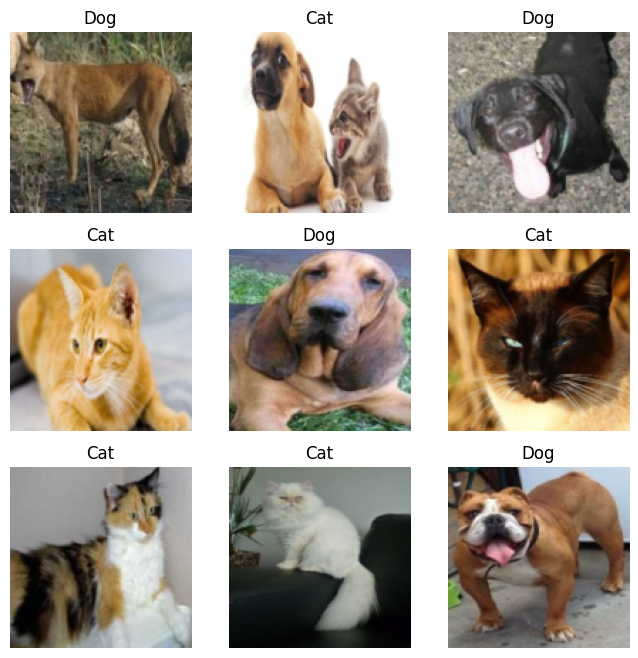

In [11]:
print("Test Set Examples:")
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(test_set), size=(1,)).item()
    img, label = test_set[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    reordered_img = np.einsum('kij->ijk',img)
    plt.imshow(reordered_img, cmap="gray")
plt.show()

In [12]:
# ---- Code block to test the accuracy of our trained model

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 74 %
